# **Importando as bibliotecas necessárias**

In [ ]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

# **Leitura da Base de Dados**

In [ ]:
data = pd.read_csv('Corpus_processado3.csv', encoding='latin-1', sep=';')
data.head()

,abstract,classe
0,antitumorpromot principl angelica keiskei pote...,positive
1,effect catechin mous lung carcinoma cell adhes...,positive
2,cyclooxygenas inhibitor potenti properti colon...,positive
3,phase novel sulfonamid discov slowgrow colon c...,positive
4,retinoid iv design synthesi structureact ditbu...,positive


In [ ]:
data.isnull().values.any()
data.shape

(400, 2)

In [ ]:
data["abstract"][3]

'phase novel sulfonamid discov slowgrow colon carcinoma cell screen model exhibit broad spectrum antitumor activ against human xenograft mechan action arrest cell phase cell cycl inhibit tubulin polymer object phase maximum allow dose mad pharmacokinet singl repeat dose singledos administ oral patient dose doselimit peripher neuropathi dose hematolog gastrointestin mild repeateddos patient dose per doselimit peripher neuropathi intestin paralysi gastrointestin dosedepend not sever hematolog not dosedepend pharmacokinet singledos rapid plasma level after disappear variat area plasma concentrationtim curv auc patient dosedepend manner total recoveri urin after indic favor absorpt elimin profil chang plasma level repeateddos indic did not accumul singledos spinal cord metastasi exhibit reduct patient uterin sarcoma minor mr pulmonari adenocarcinoma patient repeateddos decreas carcinoembryon antigen cea squamous cell carcinoma antigen scc patient stomach patient recurr uterin cervic carcin

Verificando se o conjunto de dados contém algum valor NULL ou não. Finalmente, imprimimos a forma do nosso conjunto de dados.

Imprimindo as 5 primeiras linhas do conjunto de dados usando o método head().

# **Distribuição dos sentimentos**

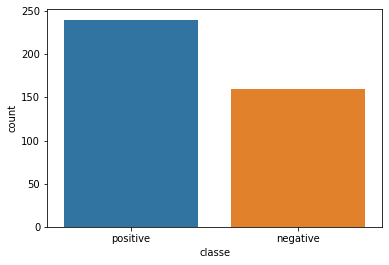

In [ ]:
import seaborn as sns

sns.countplot(x='classe', data=data)

# **Pré-processamento de dados**

O conjunto de dados continha pontuações e etiquetas HTML. Nesta secção iremos definir uma função que toma uma cadeia de texto como parâmetro e depois executa o pré-processamento da cadeia de caracteres para remover caracteres especiais e etiquetas HTML da cadeia. Finalmente, a cadeia de caracteres é devolvida à função de chamada. 


In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

No método preprocess_text(), o primeiro passo é remover as etiquetas HTML. Para remover as tags HTML, a função remove_tags() foi definida. A função remove_tags substitui simplesmente qualquer coisa entre a abertura e o fecho <> por um espaço vazio.

Na função preprocess_text, tudo é removido excepto letras maiúsculas e minúsculas em inglês, o que resulta em caracteres únicos que não fazem sentido. Por exemplo, quando se remove o apóstrofo da palavra "Mark's", o apóstrofo é substituído por um espaço vazio. Assim, ficamos com um único caracter "s".

Em seguida, removemos todos os caracteres únicos e substituímo-lo por um espaço que cria múltiplos espaços no nosso texto. Finalmente, removemos também os espaços múltiplos do nosso texto.

Em seguida, pré-processamos as nossas revisões e armazenamo-las numa nova lista, como se mostra abaixo:


In [ ]:
X = []
sentences = list(data['abstract'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [ ]:
X[3]

'phase novel sulfonamid discov slowgrow colon carcinoma cell screen model exhibit broad spectrum antitumor activ against human xenograft mechan action arrest cell phase cell cycl inhibit tubulin polymer object phase maximum allow dose mad pharmacokinet singl repeat dose singledos administ oral patient dose doselimit peripher neuropathi dose hematolog gastrointestin mild repeateddos patient dose per doselimit peripher neuropathi intestin paralysi gastrointestin dosedepend not sever hematolog not dosedepend pharmacokinet singledos rapid plasma level after disappear variat area plasma concentrationtim curv auc patient dosedepend manner total recoveri urin after indic favor absorpt elimin profil chang plasma level repeateddos indic did not accumul singledos spinal cord metastasi exhibit reduct patient uterin sarcoma minor mr pulmonari adenocarcinoma patient repeateddos decreas carcinoembryon antigen cea squamous cell carcinoma antigen scc patient stomach patient recurr uterin cervic carcin

A partir da saída, pode-se ver que as etiquetas HTML, pontuações e números foram removidos. Só ficamos com os alfabetos.

É necessário converter as nossas etiquetas em dígitos. Uma vez que só temos duas etiquetas na saída, ou seja, "positivo" e "negativo". Podemos simplesmente convertê-las em números inteiros substituindo "positivo" por dígito 1 e negativo por dígito 0, como se mostra abaixo:

In [ ]:
y = data['abstract']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

Finalmente, dividimos o nosso conjunto de dados em comboios e conjuntos de teste. O conjunto de comboios será utilizado para treinar os nossos modelos de aprendizagem profunda, enquanto o conjunto de testes será utilizado para avaliar o bom desempenho do nosso modelo.

Podemos usar o método train_test_split do módulo sklearn.model.selection

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# **Preparação da Camada Incorporadora**

Como primeiro passo, utilizaremos a classe Tokenizer do módulo keras.preprocessing.text para criar um dicionário de palavras-para-indexar. No dicionário palavra-para-índice, cada palavra do corpus é usada como chave, enquanto um índice único correspondente é usado como o valor da chave.

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

A variável X_train no explorador de variáveis, contém 40.000 listas onde cada lista contém números inteiros. Cada lista corresponde efectivamente a cada frase do conjunto de treino. O tamanho de cada lista é diferente. Isto acontece porque as frases têm comprimentos diferentes.

Fixamos o tamanho máximo de cada lista em 100. Pode tentar um tamanho diferente. As listas com tamanho superior a 100 serão truncadas para 100. Para as listas com comprimento inferior a 100, adicionaremos 0 no final da lista até atingir o comprimento máximo. Este processo chama-se acolchoamento.

O seguir o algoritmo encontra o tamanho do vocabulário e depois executa o estofamento tanto no comboio como no conjunto de testes.

In [ ]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# **Classificação de Texto com Rede Neural Simples**

O primeiro modelo de aprendizagem profunda é uma simples rede neural profunda.

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

No script acima, criamos um modelo Sequencial(). Em seguida, criamos a nossa camada de incorporação. A camada de incorporação terá um comprimento de entrada de 100, a dimensão do vector de saída será também 100. A dimensão do vocabulário será de 92547 palavras. Uma vez que não estamos a treinar as nossas próprias incrustações e utilizando a incrustação GloVe, definimos a formação para Falso e no atributo pesos passamos a nossa própria matriz de incrustação.

A camada de incrustação é então adicionada ao nosso modelo. Em seguida, uma vez que estamos a ligar directamente a nossa camada de encastramento à camada densamente ligada, achatamos a camada de encastramento. Finalmente, adicionamos uma camada densa com função de activação sigmóide.

Para compilar o nosso modelo, utilizaremos o optimizador adam, binary_crossentropy como a nossa função de perda e precisão como métrica e depois imprimiremos o resumo do nosso modelo:

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 100, 100)          607800    
                                                                 
 flatten_3 (Flatten)         (None, 10000)             0         
                                                                 
 dense_4 (Dense)             (None, 1)                 10001     
                                                                 
Total params: 617,801
Trainable params: 10,001
Non-trainable params: 607,800
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

Epoch 1/20
2/2 [==============================] - 0s 169ms/step - loss: 0.0320 - acc: 1.0000 - val_loss: 0.0620 - val_acc: 1.0000
Epoch 2/20
2/2 [==============================] - 0s 137ms/step - loss: 0.0317 - acc: 1.0000 - val_loss: 0.0615 - val_acc: 1.0000
Epoch 3/20
2/2 [==============================] - 0s 128ms/step - loss: 0.0314 - acc: 1.0000 - val_loss: 0.0611 - val_acc: 1.0000
Epoch 4/20
2/2 [==============================] - 0s 136ms/step - loss: 0.0311 - acc: 1.0000 - val_loss: 0.0607 - val_acc: 1.0000
Epoch 5/20
2/2 [==============================] - 0s 144ms/step - loss: 0.0309 - acc: 1.0000 - val_loss: 0.0603 - val_acc: 1.0000
Epoch 6/20
2/2 [==============================] - 0s 129ms/step - loss: 0.0307 - acc: 1.0000 - val_loss: 0.0599 - val_acc: 1.0000
Epoch 7/20
2/2 [==============================] - 0s 134ms/step - loss: 0.0304 - acc: 1.0000 - val_loss: 0.0595 - val_acc: 1.0000
Epoch 8/20
2/2 [==============================] - 0s 131ms/step - loss: 0.0302 - acc: 1.00

no script acima, usamos o método adequado para treinar a nossa rede neural. Note-se que estamos a treinar apenas no nosso conjunto de teste. A validação_split de 0,2 significa que 20% dos dados de treino são utilizados para encontrar a precisão do treino do algoritmo.

No final da formação, verá que a precisão do treino é de cerca de 99%.

Para avaliar o desempenho do modelo, podemos simplesmente passar o conjunto de testes para o método de avaliação do nosso modelo.

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

3/3 [==============================] - 0s 15ms/step - loss: 0.0254 - acc: 1.0000


In [ ]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
mnb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.02543320320546627
Test Accuracy: 1.0


Uma vez executado o script acima, verá que obtemos uma precisão de teste de 99%. Isto significa que o nosso modelo está a sobreajustar-se ao conjunto de treino. O sobreajustamento ocorre quando o seu modelo tem melhor desempenho no conjunto de treino do que no conjunto de teste. Idealmente, a diferença de desempenho entre o conjunto de treino e o conjunto de teste deveria ser mínima.

Traçando as diferenças de perda e precisão para os conjuntos de treino e de teste.

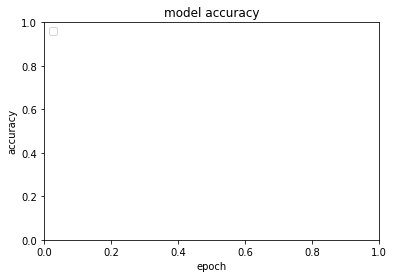

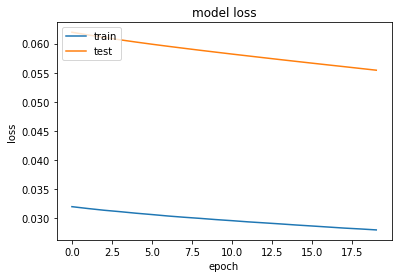

In [ ]:
import matplotlib.pyplot as plt

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

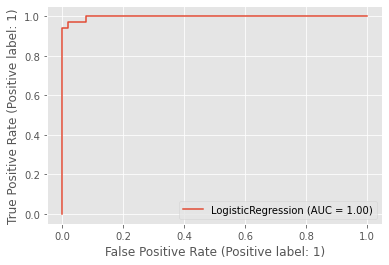

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

# extract the predicted probabilities
p_pred = model.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm
p_pred = p_pred.flatten()
# print(p_pred.round(2))
# [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

In [ ]:
# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0]


In [ ]:
print(confusion_matrix(y_test, y_pred))

[[80]]


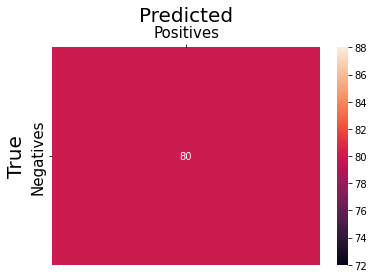

In [ ]:
# Plot confusion matrix in a beautiful manner
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('top') 
ax.xaxis.set_ticklabels(['Positives', 'Negatives'], fontsize = 15)
ax.xaxis.tick_top()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(['Negatives', 'Positives'], fontsize = 15)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80

    accuracy                           1.00        80
   macro avg       1.00      1.00      1.00        80
weighted avg       1.00      1.00      1.00        80



In [ ]:
from keras.layers.convolutional import Conv1D    
from keras.models import Sequential    
# from keras.optimizers import Adam 

model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 100)          607800    
                                                                 
 conv1d_1 (Conv1D)           (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 672,057
Trainable params: 64,257
Non-trainable params: 607,800
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)

score = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/20
2/2 [==============================] - 3s 705ms/step - loss: 0.6012 - acc: 0.7812 - val_loss: 0.4189 - val_acc: 1.0000
Epoch 2/20
2/2 [==============================] - 1s 330ms/step - loss: 0.3323 - acc: 1.0000 - val_loss: 0.2620 - val_acc: 1.0000
Epoch 3/20
2/2 [==============================] - 1s 341ms/step - loss: 0.1946 - acc: 1.0000 - val_loss: 0.1806 - val_acc: 1.0000
Epoch 4/20
2/2 [==============================] - 0s 311ms/step - loss: 0.1261 - acc: 1.0000 - val_loss: 0.1371 - val_acc: 1.0000
Epoch 5/20
2/2 [==============================] - 0s 281ms/step - loss: 0.0902 - acc: 1.0000 - val_loss: 0.1125 - val_acc: 1.0000
Epoch 6/20
2/2 [==============================] - 1s 269ms/step - loss: 0.0700 - acc: 1.0000 - val_loss: 0.0977 - val_acc: 1.0000
Epoch 7/20
2/2 [==============================] - 0s 256ms/step - loss: 0.0583 - acc: 1.0000 - val_loss: 0.0882 - val_acc: 1.0000
Epoch 8/20
2/2 [==============================] - 1s 345ms/step - loss: 0.0509 - acc: 1.00

In [ ]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.030011629685759544
Test Accuracy: 1.0


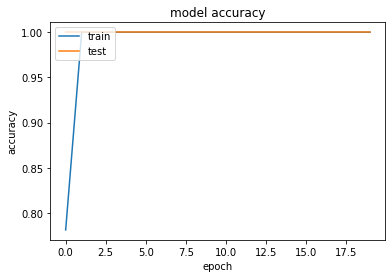

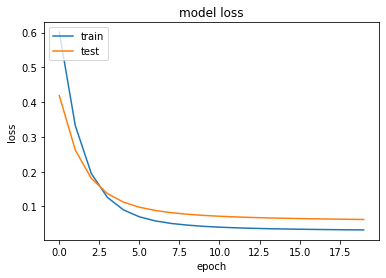

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

# extract the predicted probabilities
p_pred = model.predict(X_test)
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)
cm
p_pred = p_pred.flatten()

In [ ]:
print(classification_report(y_test, y_pred))

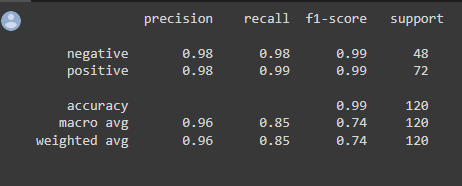